Under the condition where epoch = 100, compare three kinds of convnets using different training ways:

1. Firstly train digits 0~4, then 5~9
2. Firstly train digits 0~4, then 0~9
3. Firstly train digits 0~9

Compare way:

1. curves' shape
2. accuracy on test sets
3. **[Note]** Conclusions must be based on means of results from multiple experients, 5 at least.

You should commit:

1. Source code
2. A PDF report with details of experiments, including details of methods, results in graphs and conclusion.

 --------------------------------------------------------------

# -1. Preparation

In [1]:
#import modules
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.autograd import Variable

from IPython.display import display
%matplotlib inline

In [2]:
# define some constant variables

use_cuda = torch.cuda.is_available()
dtype_float = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
dtype_long = torch.cuda.LongTensor if use_cuda else torch.LongTensor

In [3]:
import torchvision

# prepare MNIST

path_datasets = './datasets'

transform_set = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
data_train = torchvision.datasets.MNIST(root=path_datasets, train=True, download=True, 
                                        transform=transform_set) 
data_test = torchvision.datasets.MNIST(root=path_datasets, train=False, download=True,
                                        transform=transform_set)

In [4]:
batch_size = 100
n_class = 10

##dataloader_train
dataloader_train = torch.utils.data.DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)

##dataloader_valid

indices_valid = range(len(data_test)//2)
sampler_valid = torch.utils.data.sampler.SubsetRandomSampler(indices=indices_valid)
dataloader_valid = torch.utils.data.DataLoader(dataset=data_test, batch_size=batch_size, sampler=sampler_valid)

##dataloader_test

indices_test = range(len(data_test)//2, len(data_test))
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices=indices_test)

dataloader_test = torch.utils.data.DataLoader(dataset=data_test, batch_size=batch_size, sampler=sampler_test)

## 查看三个数据迭代器的结果

,0
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851
9,5949


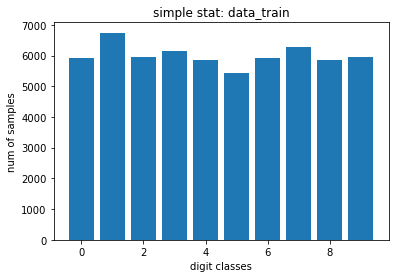

In [5]:
count = {i:0 for i in range(n_class)}
for i,data in enumerate(dataloader_train):
    xs,ys = data
    for y in ys:
        count[y] += 1

count = [count[i] for i in range(n_class)]
display(pd.DataFrame(data=count))
plt.bar(left=np.arange(n_class), height=count)
plt.xlabel('digit classes')
plt.ylabel('num of samples')
plt.title('simple stat: data_train')
plt.show()

,0
0,460
1,571
2,530
3,500
4,500
5,456
6,462
7,512
8,489
9,520


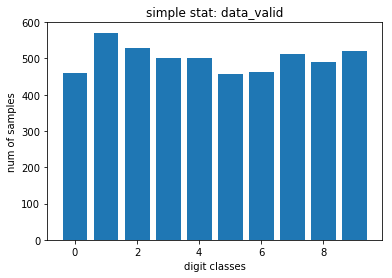

In [6]:
count = {i:0 for i in range(n_class)}
for i,data in enumerate(dataloader_valid):
    xs,ys = data
    for y in ys:
        count[y] += 1

count = [count[i] for i in range(n_class)]
display(pd.DataFrame(data=count))
plt.bar(left=np.arange(n_class), height=count)
plt.xlabel('digit classes')
plt.ylabel('num of samples')
plt.title('simple stat: data_valid')
plt.show()

,0
0,520
1,564
2,502
3,510
4,482
5,436
6,496
7,516
8,485
9,489


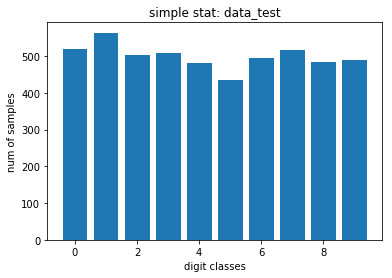

In [7]:
count = {i:0 for i in range(n_class)}
for i,data in enumerate(dataloader_test):
    xs,ys = data
    for y in ys:
        count[y] += 1

count = [count[i] for i in range(n_class)]
display(pd.DataFrame(data=count))
plt.bar(left=np.arange(n_class), height=count)
plt.xlabel('digit classes')
plt.ylabel('num of samples')
plt.title('simple stat: data_test')
plt.show()

# 0. ConvNet class

In [100]:
from  torch.nn import functional as F

n_channels = 1
n_class = 10
size_image = 28

depth = [8, 16, 32]
fc = [1024, 128, n_class]
ksize = [5, 5, 5]
pad = [2, 2, 2]

net_names = []

# define class

class ConvNet(nn.Module):
    
    def __init__(self, init_name):
        super(ConvNet, self).__init__()
        # init
        global net_names
        assert init_name not in net_names, "Name existed: {}".format(net_names)
        net_names.append(init_name)
        self.name = init_name
        
        # conv-net
        self.conv00 = nn.Conv2d(in_channels=n_channels, out_channels=depth[0], kernel_size=ksize[0], padding=pad[0])
        self.conv01 = nn.Conv2d(in_channels=depth[0], out_channels=depth[1], kernel_size=ksize[1], padding=pad[1])
        self.conv02 = nn.Conv2d(in_channels=depth[1], out_channels=depth[2], kernel_size=ksize[2], padding=pad[2])
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # full-connect
        self.fc00 = nn.Linear(in_features=(size_image//4//2)*(size_image//4//2)*depth[2], out_features=fc[0])
        self.fc01 = nn.Linear(in_features=fc[0], out_features=fc[1])
        self.fc02 = nn.Linear(in_features=fc[1], out_features=fc[2])
        
        self.bn1d = nn.BatchNorm1d(num_features=fc[1])
        
    def rename(self, new_name):
        global net_names
        net_names.remove(self.name)
        self.name = new_name
        net_names.append(new_name)
    
    def forward(self, x, training=True):
        x = F.leaky_relu(self.conv00(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv01(x))
        x = self.maxpool(x)
        x = F.leaky_relu(self.conv02(x))
        x = self.maxpool(x)
        x = x.view(-1, (size_image//4//2)*(size_image//4//2)*depth[2])
        
        x = F.leaky_relu(self.fc00(x))
        x = F.dropout(x, training=self.training)
        x = F.leaky_relu(self.fc01(x))
        x = self.bn1d(x)
        x = F.leaky_relu(self.fc02(x))
        
        return x

# 1. ConvNet_0 [0~4 -> 5~9]

## 1.1 train and test

In [101]:
# init
net = ConvNet().cuda() if use_cuda else ConvNet()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

TypeError: __init__() missing 1 required positional argument: 'init_name'

报错过 `Assertion `cur_target >= 0 && cur_target < n_classes' failed.`，于是打印预测值，发现预测值是

```
0.1296
-0.0020
-0.0002
-0.0004
 0.0679
 0.0892
-0.0001
-0.0057
-0.0023
-0.0033
 0.4178
-0.0057
 0.3687
-0.0001
 0.4879
-0.0012
-0.0029
 0.4439
-0.0038
-0.0007
-0.0016
 0.0780
-0.0021
-0.0010
-0.0016
-0.0034
 0.2390
-0.0039
-0.0032
-0.0005
-0.0031
-0.0033
-0.0007
 1.0161
-0.0013
-0.0033
 0.1488
```

于是我估计前向传播出问题了，看了一下 `forward`，果然，由于延续了之前的代码，没有改成 softmax


后来又报错 `Expected 2 or 4 dimensions (got 1) `，仔细查看网络结构，对比现有网络和之前成功的网络，发现自己通不过的网络里，最后一层全连接是 1 个结点，想到估计是这个导致 softmax 没法输出（本应接受 `n_class` 个输入才能有对应输出的）

后来报错 `inconsistent tensor size, expected r_ [1000], ta [1000] and tb [100] to have the same number of elements, but got 1000, 1000 and 100 elements respectively at /opt/conda/conda-bld/pytorch_1502004572321/work/torch/lib/TH/generic/THTensorMath.c:2829`，然后我估计是形状不匹配，于是在测试前加入形状代码，发现现在一个输出是 10 维度，一个原始数据是 1 维，当然无法比较。那么为什么原来的网络可以呢？对比后发现，原来的网络在测试时使用了 `np.argmax` 来转换。于是我就想，干脆在网络输出前用 `torch.max` 来取值就好了

In [102]:
def evaludate_acc(y, target):
    if isinstance(target, torch.autograd.Variable):
        target = target.data
    if isinstance(y, torch.autograd.Variable):
        y = y.data
    pred = torch.max(y, dim=1)[-1]
    rights = pred.eq(target).sum()
    length = y.size()[0]
    acc = 1.0 * rights / length
    return (acc, rights, length)

In [120]:
# define training function using specified digits


def train_net(net, loss_func, optimizer, digit_range, sum_epochs=15, interval_valid=50):
    bag_loss = {'train':[], 'valid':[]}
    bag_acc = {'train':[], 'valid':[]}
    for epoch in range(sum_epochs):
        for idx,batch in enumerate(dataloader_train):
            # set net state
            net.train()

            # fetch batch for this round, then choose points that are in `digit_range`
            xs_raw, ys_raw = batch
            xs, ys = [], []
            for (data,label) in zip(xs_raw, ys_raw):
                if label in digit_range:
                    xs.append(data.unsqueeze(0))
                    ys.append(label)
            xs = torch.cat(xs)
            ys = torch.from_numpy(np.array(ys))
            xs, ys = (xs.cuda(), ys.cuda()) if use_cuda else (xs, ys)
            
            # pack in Variable
            xs, ys = Variable(xs), Variable(ys)  # easy to forget packing `ys` in `Variable`

            # predictions
            preds = net(xs)

            # count loss
            loss_train = loss_func(preds, ys)

            # clear grad and backwoard
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            if idx % interval_valid == 0:
                # set net state
                net.eval()

                # TODO: validation
                acc_valid, loss_valid = [], []
                for jdx, batch_v in enumerate(dataloader_valid):
                    xs_v, ys_v = batch_v
                    xs_v, ys_v = (xs_v.cuda(), ys_v.cuda()) if use_cuda else (xs_v, ys_v)
                    xs_v, ys_v = Variable(xs_v), Variable(ys_v)
                    preds_v = net(xs_v)
                    loss_valid_raw = loss_func(preds_v, ys_v)
                    loss_valid.append(loss_valid_raw.cpu().data.numpy() if use_cuda else loss_valid_raw.data.numpy())
                    acc_valid.append(evaludate_acc(preds_v, ys_v)[0])

                acc_train = evaludate_acc(net(Variable(xs_raw)), Variable(ys_raw))[0]
                acc_valid = np.mean(acc_valid)
                loss_valid = np.mean(loss_valid)
                bag_loss['train'].append(loss_train.cpu().data.numpy() if use_cuda else loss_train.data.numpy())
                bag_loss['valid'].append(loss_valid)
                bag_acc['train'].append(acc_train)
                bag_acc['valid'].append(acc_valid)

                print('[Epoch: {}/{}] [Batch: {}/{}] [Loss-mean(train): {:.4f}] [Loss-mean(validation): {:.4f}] \
[Acc-mean(train): {:.4f}] [Acc-mean(validation): {:.4f}]'.format(
                    epoch, sum_epochs, idx, len(dataloader_train),
                    np.mean(bag_loss['train']), 
                    np.mean(bag_loss['valid']), 
                    np.mean(bag_acc['train']), 
                    np.mean(bag_acc['valid'])
                ))
                
    return (bag_loss, bag_acc, net)

In [161]:
class Coacher(object):
    
    def __init__(self, stage_names=['train', 'valid', 'test'], ind_names=['loss', 'acc']):
        # storage
        self.stage_names = stage_names
        self.ind_names = ind_names
        self.results = {ind:{stage:[] for stage in stage_names} for ind in ind_names}
        
    def pipeline_helper(self, n_iters, net, loss_func, optimizer, digit_rangesss, 
                        sum_epochs=15, interval_valid=50):
        for i in range(n_iters):
            self.train_helper(net, loss_func, optimizer, digit_rangesss, 
                              sum_epochs=sum_epochs, interval_valid=interval_valid)
            self.test_helper(net)
            self.save(mode='file', netname=net.name, suffix=str(i))
            num_valid = sum_epochs * len(dataloader_train) // interval_valid
            self.plotter(net.name, plot_test=False, suffix=str(i), num_valid=num_valid)
            self.plotter(net.name, plot_test=True, suffix=str(i), num_valid=num_valid)
            print('Round {}: OK'.format(i))
        print('==================================================')
        print('Finish all the pipeline.')    
        
        
    def train_helper(self, net, loss_func, optimizer, digit_rangesss, sum_epochs=15, interval_valid=50):
        # train and validate, using digit_range sequences
        for idx,digit_range in enumerate(digit_rangesss):
            raw_out = {ind:[] for ind in self.ind_names}

            raw_out['loss'], raw_out['acc'], net = train_net(
                net=net, loss_func=loss_func, optimizer=optimizer, digit_range=digit_range,
                sum_epochs=sum_epochs//len(digit_rangesss), interval_valid=interval_valid
            )
            
            # save in RAM: train_data and valid_data 
            self.save(mode='dict-results', data=raw_out)
            print('Save data(train & validation): OK in RAM, for', digit_range)
        print('Train net: OK')
        
    def test_helper(self, net):
        # test(evaluate)
        net.eval()
        
        raw_out = {ind:{'test':[]} for ind in self.ind_names}
        for kdx, batch_t in enumerate(dataloader_test):
            xs_t, ys_t = batch_t
            xs_t, ys_t = (xs_t.cuda(), ys_t.cuda()) if use_cuda else (xs_t, ys_t)
            xs_t, ys_t = Variable(xs_t), Variable(ys_t)
            preds_t = net(xs_t)
            loss_test_raw = loss_func(preds_t, ys_t)
            raw_out['loss']['test'].append(loss_test_raw.cpu().data.numpy() if use_cuda else loss_test_raw.data.numpy())
            raw_out['acc']['test'].append(evaludate_acc(preds_t, ys_t)[0])
        
        # save in RAM: test_data
        self.save(mode='dict-results', data=raw_out, stages=['test'])
        print('Save data(test): OK in RAM')
        
    def save(self, mode, data=None, netname=None, dirname='outputs', stages=['train', 'valid'], suffix=None):
        if 'dict-results' == mode:
            assert data is not None, 'Your should specify the data you want to save in RAM.'
            for ind in self.ind_names:
                for stage in stages:
                    items = [i[0] if isinstance(i, np.ndarray) else i for i in data[ind][stage]]
                    if stage not in self.results[ind]:
                        self.results[ind][stage] = copy.deepcopy(items)
                    else:
                        self.results[ind][stage].extend(items)
        
        if 'file' == mode:
            assert netname is not None, 'You should specify the **NAME** of this neural network.'
            if not os.path.isdir(dirname):
                os.mkdir(dirname)
            
            lacks = []
            for stage in self.stage_names:
                tmp_pd = {ind:copy.deepcopy(self.results[ind][stage]) for ind in self.ind_names}
                tmp_pd = pd.DataFrame(data=tmp_pd, columns=self.ind_names)
                if suffix:
                    filename = os.path.join(os.getcwd(), dirname, '{}-sheet-{}-{}.csv'.format(netname, stage, suffix))
                else:
                    filename = os.path.join(os.getcwd(), dirname, '{}-sheet-{}.csv'.format(netname, stage))
                with open(filename, 'a') as tofile:
                    tmp_pd.to_csv(tofile)
                print('Save data in file OK:', filename)
    
    def plotter(self, netname, suffix=None, plot_test=True, num_valid=None):
        if plot_test:
            # plot: test
            
            x_inds = np.arange(len(dataloader_test))
            fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,5))
            ax0.plot(x_inds, self.results['loss']['test'], label='loss_test')
            ax1.plot(x_inds, self.results['acc']['test'], label='acc_test')
            ax0.set_xlabel('num_iter')
            ax1.set_xlabel('num_iter')
            ax0.set_ylabel('loss')
            ax1.set_ylabel('accuracy')
            
            if suffix:
                filename = os.path.join(os.getcwd(), 'outputs', 
                                        '{}-curves_test-{}'.format(netname, suffix))
            else:
                filename = os.path.join(os.getcwd(), 'outputs', '{}-curves_test'.format(netname))
                
            plt.savefig(filename)
        else:
            # plot: train & validation
            
            fig, axes_raw = plt.subplots(1, len(self.ind_names), figsize=(15, 5))
            axes = {self.ind_names[i]:ax for i,ax in enumerate(axes_raw) }
            
            assert num_valid is not None, 'You should specify how many times \
the validation process executed each round.'
            x_inds = np.arange(num_valid)
            for ind in ['loss', 'acc']:
                for stage in ['train', 'valid']:
                    axes[ind].plot(x_inds, self.results[ind][stage], label='{}_{}'.format(ind, stage))
                
                axes[ind].set_xlabel('num_iter')
                axes[ind].set_ylabel(ind)
                axes[ind].set_title('data on: convnet_0')
                axes[ind].legend()
            
            plt.tight_layout(w_pad=10)
            
            if suffix:
                filename = os.path.join(os.getcwd(), 'outputs', 
                                        '{}-curves-train_validation-{}'.format(netname, suffix))
            else:
                filename = os.path.join(os.getcwd(), 'outputs', '{}-curves-train_validation'.format(netname))
                
            plt.savefig(filename)

            # # fig.show() 
            # comment the command above to avoid warning 
            #`UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure`

In [163]:
net_names = []

In [164]:
test_coacher = Coacher()

In [165]:
test_convnet = ConvNet('test_convnet')

[Epoch: 0/2] [Batch: 0/600] [Loss-mean(train): 2.3505] [Loss-mean(validation): 2.3030] [Acc-mean(train): 0.0200] [Acc-mean(validation): 0.1040]
[Epoch: 0/2] [Batch: 50/600] [Loss-mean(train): 2.3519] [Loss-mean(validation): 2.3028] [Acc-mean(train): 0.0650] [Acc-mean(validation): 0.1063]
[Epoch: 0/2] [Batch: 100/600] [Loss-mean(train): 2.3370] [Loss-mean(validation): 2.3031] [Acc-mean(train): 0.0767] [Acc-mean(validation): 0.1057]
[Epoch: 0/2] [Batch: 150/600] [Loss-mean(train): 2.3347] [Loss-mean(validation): 2.3035] [Acc-mean(train): 0.0800] [Acc-mean(validation): 0.1050]
[Epoch: 0/2] [Batch: 200/600] [Loss-mean(train): 2.3327] [Loss-mean(validation): 2.3037] [Acc-mean(train): 0.0860] [Acc-mean(validation): 0.1052]
[Epoch: 0/2] [Batch: 250/600] [Loss-mean(train): 2.3330] [Loss-mean(validation): 2.3038] [Acc-mean(train): 0.0833] [Acc-mean(validation): 0.1050]
[Epoch: 0/2] [Batch: 300/600] [Loss-mean(train): 2.3368] [Loss-mean(validation): 2.3038] [Acc-mean(train): 0.0843] [Acc-mean(va

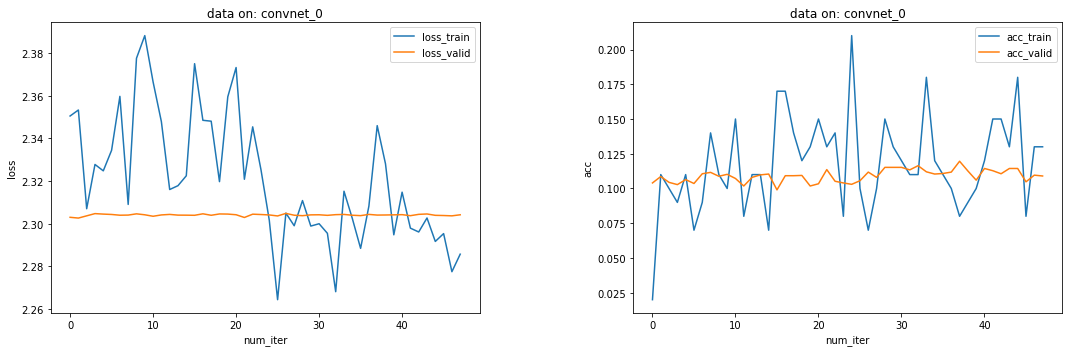

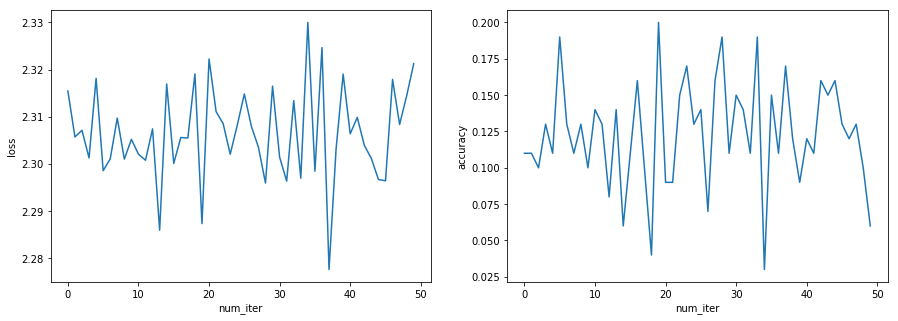

In [166]:
test_coacher.pipeline_helper(
    n_iters=1, 
    net=test_convnet, 
    loss_func=loss_func, 
    optimizer=optimizer, 
    digit_rangesss=[range(4), range(4, 9+1)],
    sum_epochs=4
)

## 1.2 details

blabla...

# 2. ConvNet_1 [0~4 -> 0~9]

## 2.1 train and test

In [ ]:
# define class

In [ ]:
# train using 0~4

In [ ]:
# train using 0~9

In [ ]:
# test

## 2.2 details

blabla...

# 3. ConvNet_2 [0~9]

## 3.1 train and test

In [ ]:
# define class

In [ ]:
# train using 0~9

In [ ]:
# test

## 3.2 details

blabla...